In [1]:
using Revise
includet("../../scripts/competing_mms.jl")

┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ Symbolics → SymbolicsForwardDiffExt
│  └─ Symbolics → SymbolicsPreallocationToolsExt
│ Precompilation will also be skipped for the following, which depend on the above cycle:
│   SSMC
│   MLSolver
└ @ Pkg.API.Precompilation ~/.julia/juliaup/julia-1.10.10+0.x64.linux.gnu/share/julia/stdlib/v1.10/Pkg/src/precompilation.jl:583
Precompiling packages...
  12323.7 ms  ✓ SSMCMain
  1 dependency successfully precompiled in 15 seconds. 540 already precompiled. 4 skipped due to circular dependency.


In [2]:
using GLMakie
using CairoMakie
CairoMakie.activate!()

# No-space

In [62]:
ps = make_comp_mms_params(
    10.,
    1., 1.,
    0.9, 1.,
    1., 2.
)
p = make_mmicrm_problem(ps, [1., 1., 0., 0., 0.], 1e2)
tol = 1e-8
@time s = solve(p, QNDF();
    abstol=tol, reltol=tol,
);

  0.000517 seconds (1.45 k allocations: 148.953 KiB)


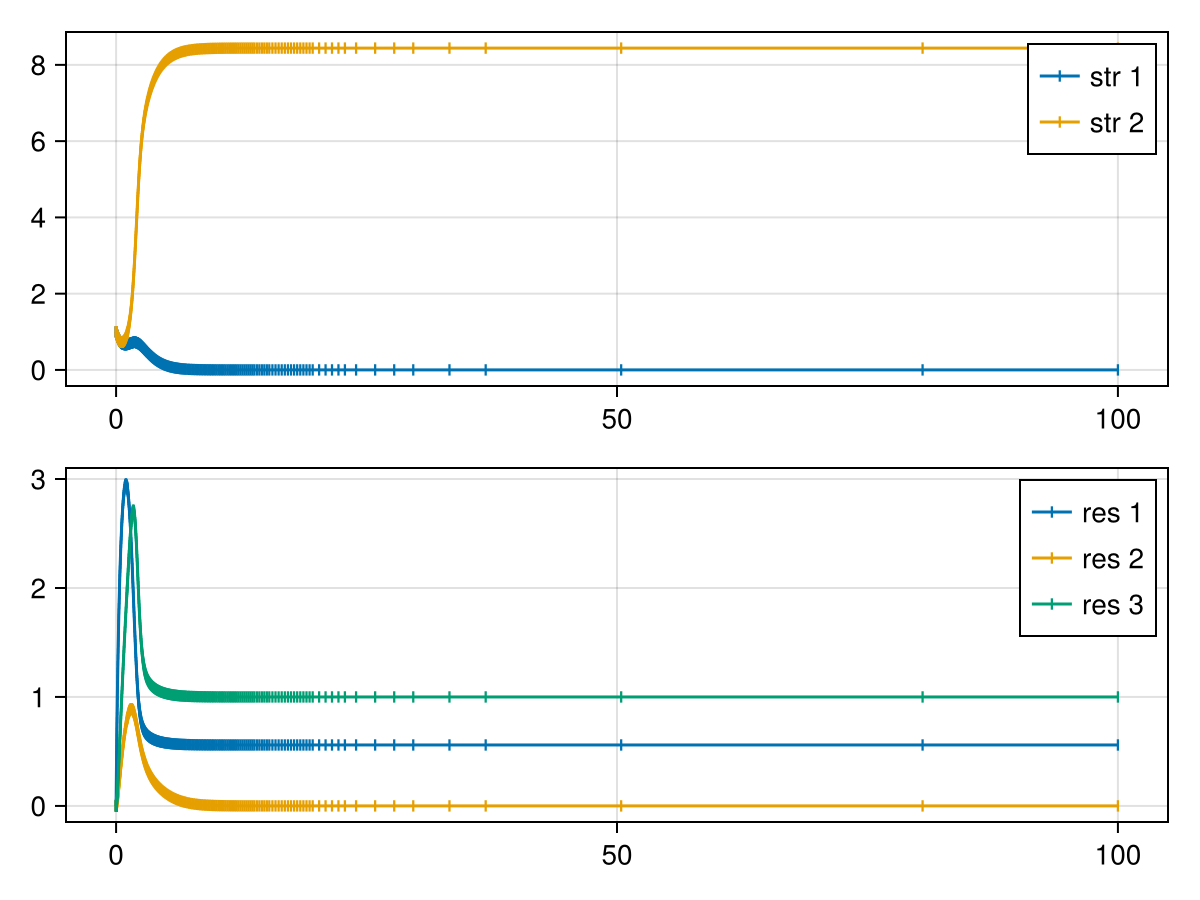

In [63]:
f = plot_mmicrm_sol(s)
# display(GLMakie.Screen(), f.figure)
f

# Spatial

In [39]:
ps = make_comp_mms_params(
    10.,
    0.9, 1.,
    1., 1.,
    1., 1.1
)
Ds = SA[1e-6, 1e-6, 1., 1., 1.]

L = 5
sN = 2000
dx = L / sN

nothing

In [40]:
N0 = 1.
u0 = expand_u0_to_size((sN,), [N0, N0, 0., 0., 0.])
fu0 = clamp.(perturb_u0_uniform(2, 3, u0, 1.), 0., Inf);

In [41]:
Nxx = 1.
fu0 = fill(0., 5, sN)
N1 = @view fu0[1,:]
N2 = @view fu0[2,:]
N1 .= Nxx
N2 .= Nxx

add_1d_many_sines!(N1, 100, Nxx / 5, dx)
add_1d_many_sines!(N2, 100, Nxx / 5, dx)

fu0

5×2000 Matrix{Float64}:
 1.24237   1.26455   1.28675   1.30897   …  1.17608   1.19813   1.22023
 0.633751  0.611281  0.588925  0.566704     0.701633  0.678948  0.656313
 0.0       0.0       0.0       0.0          0.0       0.0       0.0
 0.0       0.0       0.0       0.0          0.0       0.0       0.0
 0.0       0.0       0.0       0.0          0.0       0.0       0.0

In [42]:
sps = BSMMiCRMParams(
    ps,
    Ds,
    CartesianSpace{1,Tuple{Periodic}}(SA[dx]),
    nthreads()
)

p = make_smmicrm_problem(sps, fu0, 1e8)
tol = 1e-8
@time s = solve(p, QNDF();
    abstol=tol, reltol=tol,
);

  4.786343 seconds (1.98 M allocations: 1.590 GiB, 31.37% gc time)


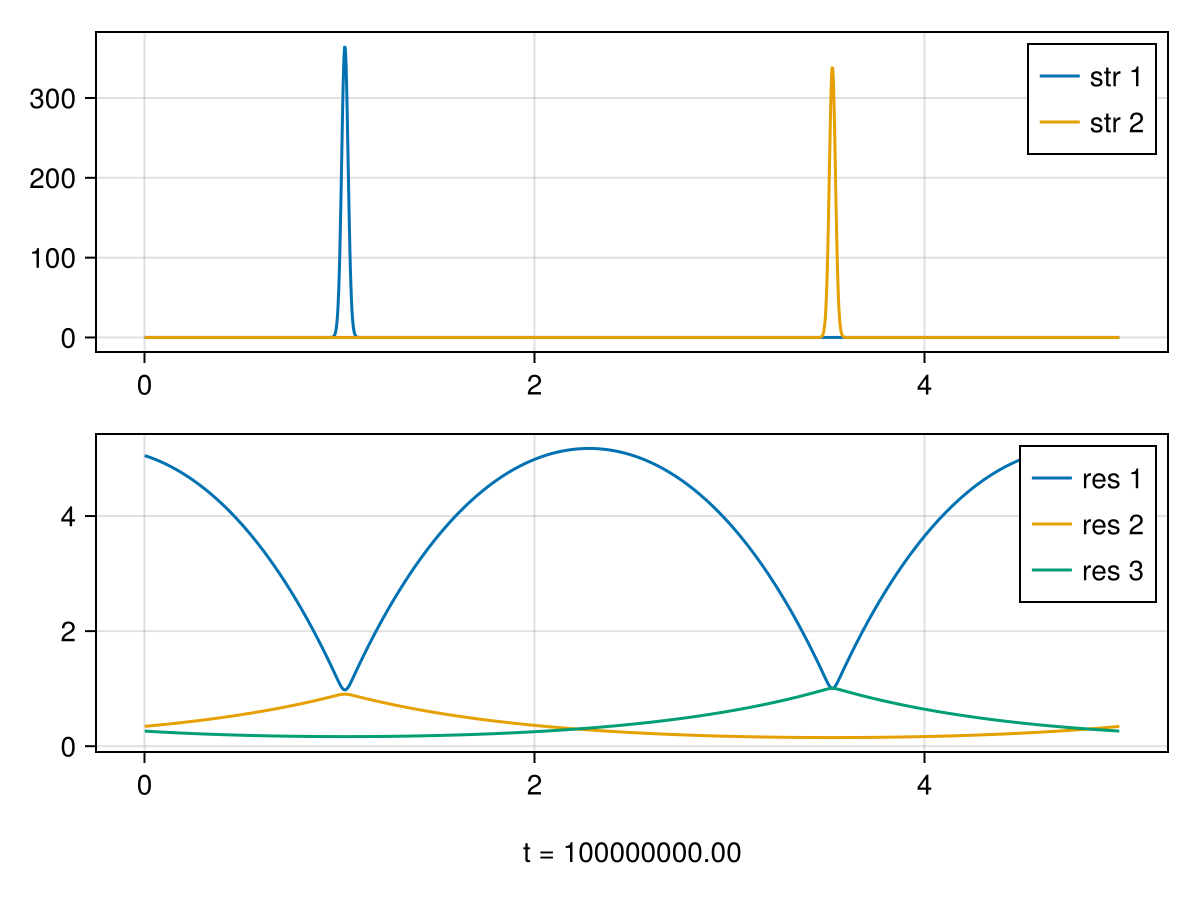

In [50]:
f = plot_1dsmmicrm_sol_snap(s, -1)

In [51]:
Label(f[0,1], "MM1 has m of 0.9, MM2 has c of 1.1, everything else is 1"; tellwidth=false)
Makie.save("../../data/comp_mms/eg1.pdf", f)

CairoMakie.Screen{PDF}


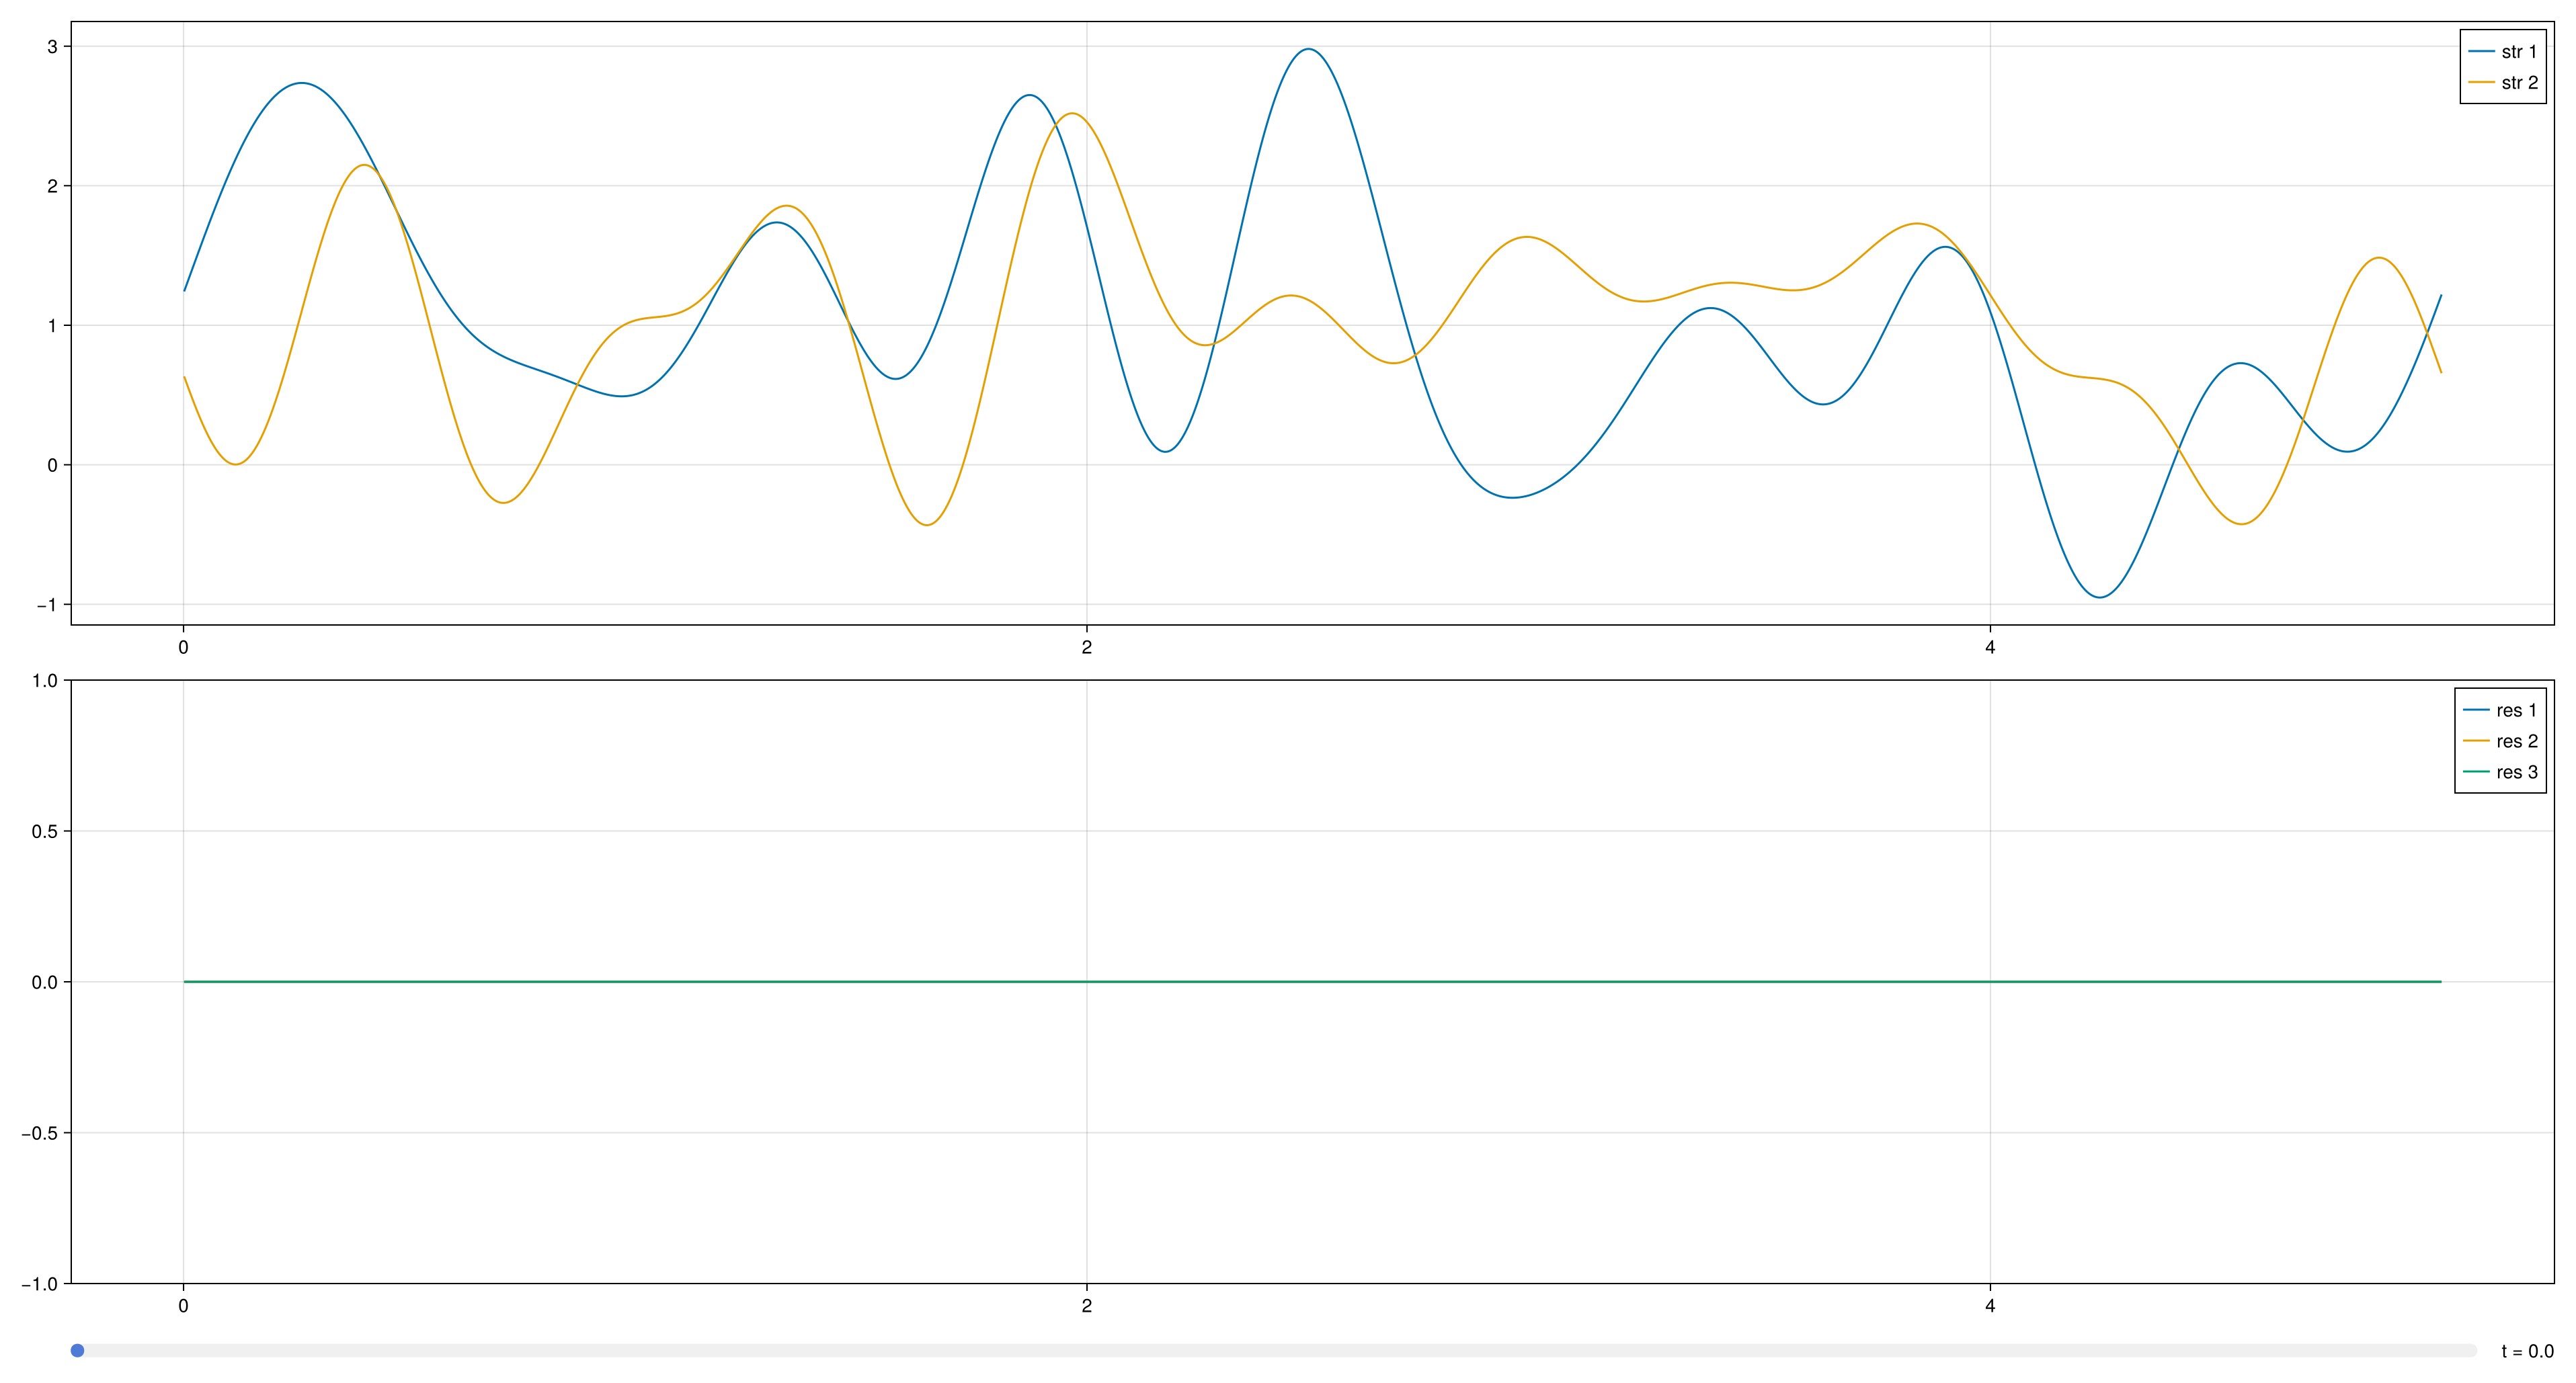

In [45]:
faa = plot_1dsmmicrm_sol_interactive(s)
display(GLMakie.Screen(), faa)
faa

# Various testing

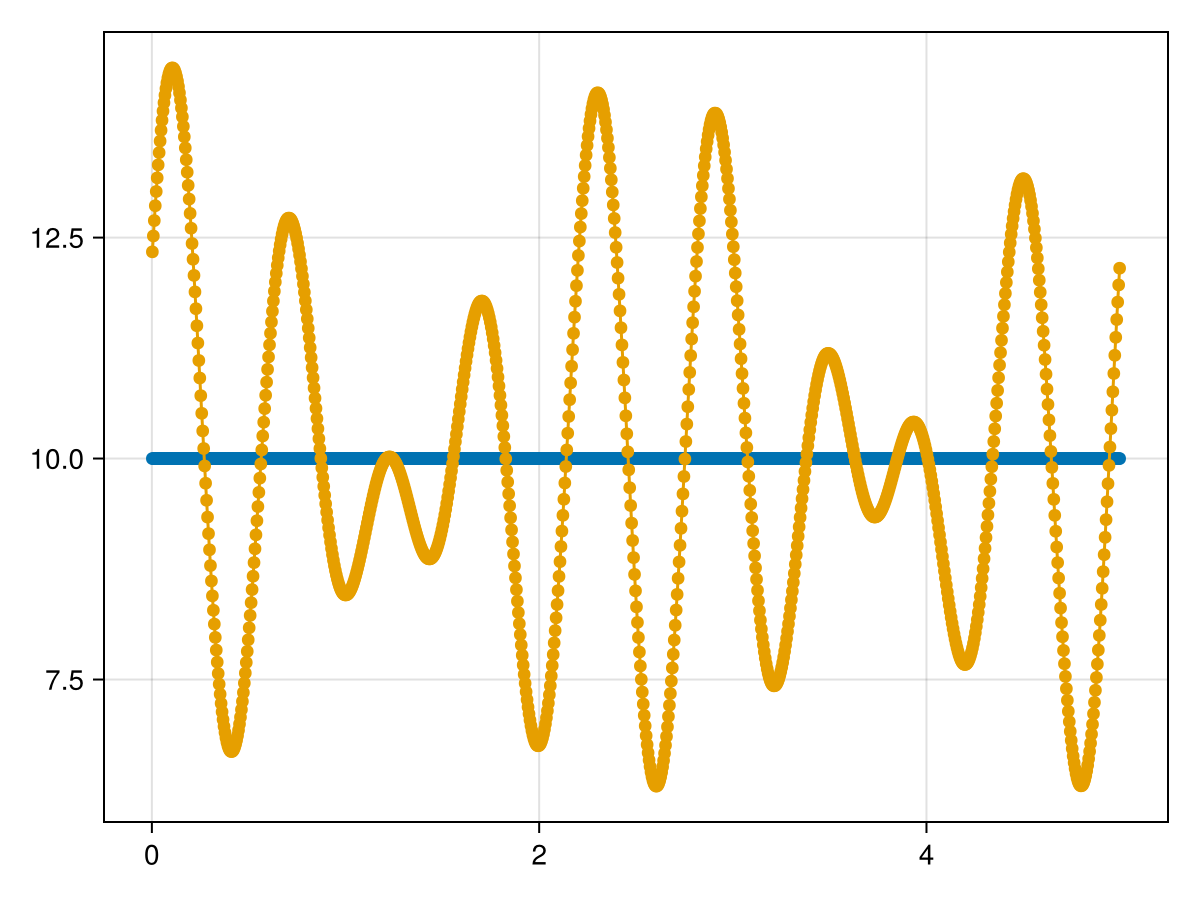

In [119]:
sN = 1000
L = 5
dx = L / sN

u1 = fill(10., sN);
u2 = copy(u1)
add_1d_many_sines!(u2, 4, 3, dx)

xs = ((1:sN) .- 0.5) .* dx

fap = scatterlines(xs, u1)
scatterlines!(fap.axis, xs, u2)

fap